In [1]:
import pandas as pd
data = pd.read_csv('/Users/fipm/code/abefarkas/Thalassa_Regime_Classifier/raw_data/data_set_v2.csv')

In [2]:
data.head(3)



,primary_key,bp1,bs1,bp2,bs2,bp3,bs3,bp4,bs4,bp5,...,ap16,as16,ap17,as17,ap18,as18,ap19,as19,ap20,as20
0,2022-05-19 00:00:00,28700.600000,0.082333,28699.100000,0.017000,28699.000000,1.609667,28697.400000,0.105000,28696.8,...,28704.6,0.268333,28704.833333,0.534333,28704.966667,0.014000,28705.133333,0.027000,28705.300000,0.192000
1,2022-05-19 00:00:01,28700.600000,0.046000,28699.400000,0.012333,28699.033333,0.934000,28697.933333,0.534333,28697.0,...,28704.2,0.207000,28704.366667,0.045667,28704.466667,0.001667,28704.700000,0.101333,28704.866667,0.051000
2,2022-05-19 00:00:02,28695.633333,0.285500,28694.766667,0.077333,28693.733333,0.506000,28693.600000,0.978667,28692.5,...,28702.3,0.885667,28702.400000,0.553333,28702.733333,0.098667,28702.833333,0.001667,28702.966667,0.505333


In [22]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timezone, timedelta
import joblib

class DataModelPipeline():
    def __init__(self):
        self.preprocessing = Pipeline([
            ('Imputer', SimpleImputer(strategy = 'mean')),
            # ('scaler', MinMaxScaler()),
            ])
        self.data = None
        self.y = None
        self.X = None

    def financial_features(self, data):
        self.data = data.copy()

        # unix_timestamp = lambda x: datetime.fromtimestamp(x/1000.0, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
        str2date = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
        # self.data['primary_key']=self.data['ts'].apply(unix_timestamp).apply(str2date)
        self.data['primary_key']=self.data['primary_key'].apply(str2date)
        
        
        
        
        # self.data['less30s']=self.data['primary_key'].dt.second<30
        # self.data['primary_key']=self.data['primary_key'].dt.strftime('%Y-%m-%d %H:%M')+self.data['less30s'].apply(lambda x: ':15' if x==True else ':45')
        # self.data.drop(columns=['less30s'], inplace=True)
        

        # WAP
        self.data['WAP'] = (self.data['bp1']*self.data['bs1']
                +self.data['bp2']*self.data['bs2']
                +self.data['ap1']*self.data['as1']
                +self.data['ap2']*self.data['as2'])/(self.data['bs1']+
                                            self.data['bs2']+
                                            self.data['as1']+
                                            self.data['as2'])

        # log_price
        self.data['log_price'] = 100*np.log(self.data['WAP'])

        # log_returns
        self.data['log_returns'] = self.data.log_price.diff()


        # other features
        self.data['spread'] = ((self.data['ap1']/self.data['bp1']) - 1)
        self.data['spread_sq']=self.data['spread']*self.data['spread']
        
        
        self.data['full_bid_depth'] = self.data[['bs1', 'bs2', 'bs3','bs4', 'bs5', 'bs6','bs7', 'bs8', 'bs9','bs10',
                            'bs11', 'bs12', 'bs13','bs14', 'bs15', 'bs16','bs17', 'bs18', 'bs19','bs20']].sum(axis=1)
        self.data['full_ask_depth'] = self.data[['as1', 'as2', 'as3','as4', 'as5', 'as6','as7', 'as8', 'as9','as10',
                            'as11', 'as12', 'as13','as14', 'as15', 'as16','as17', 'as18', 'as19','as20']].sum(axis=1)
        self.data['BBAOFI'] = (self.data['bs1']-self.data['as1'])/(self.data['bs1']+self.data['as1'])
        self.data['First2OFI'] = ((self.data['bs1']+self.data['bs2']) - (self.data['as1']+self.data['as2']))/ ((self.data['bs1']+self.data['bs2']) + (self.data['as1']+self.data['as2']))
        self.data['FDOFI'] = (self.data['full_bid_depth']-self.data['full_ask_depth'])/(self.data['full_bid_depth']+self.data['full_ask_depth'])
         
        # realized_volatility
        sigma = lambda x: (np.nansum(x**2))**0.5
        y = self.data[['log_returns']]

        rolling=2*60
        y = y.rolling(rolling).apply(sigma)

        
        primary_key=self.data['primary_key']
        
        self.data = self.data.rolling(rolling).mean()        
        self.data['realized_volatility']=y.values
        self.data['primary_key']=primary_key
        
        #####
        
        # sigma = lambda x: (np.nansum(x['log_returns']**2))**0.5
        # y = self.data[['primary_key','log_returns']].groupby(['primary_key']).apply(sigma)

        # self.data = self.data.groupby(['primary_key']).mean()
        # self.data.reset_index(drop=False, inplace=True)
        # self.data['realized_volatility']=y.values
            
        return self.data

    def pipeline(self, data):
        data = data.dropna().reset_index(drop=True)
        # self.y = data[['primary_key','realized_volatility']].set_index('primary_key')
        self.y = data[['realized_volatility']]

        X = data.drop(columns=['realized_volatility','primary_key'])
        self.X = pd.DataFrame(self.preprocessing.fit_transform(X), columns=self.preprocessing.get_feature_names_out())
        return self.y, self.X

    def predict(self, model, steps=1):
        # only works for arima
        #n = pd.DataFrame.from_dict({'realized_volatility':new_data})
        #y_new = pd.concat((self.y, n)).reset_index(drop=True)
        new_model = model.apply(self.y)
        predictions = new_model.forecast(steps)
        predictions = pd.DataFrame.from_dict({'realized_volatility':predictions.values})
        y_new = pd.concat((self.y, predictions)).reset_index(drop=True)
        return y_new

In [23]:

data_model_pipeline = DataModelPipeline()
# construct finantial features
df = data_model_pipeline.financial_features(data)
# getting endogenous and exogenous variables to be used
# to train a model
y, X = data_model_pipeline.pipeline(df)




/var/folders/91/6wbfy1kd3c54vx64tq8sck_00000gn/T/ipykernel_1323/942635215.py:72: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['primary_key'], dtype='object')
  self.data = self.data.rolling(rolling).mean()


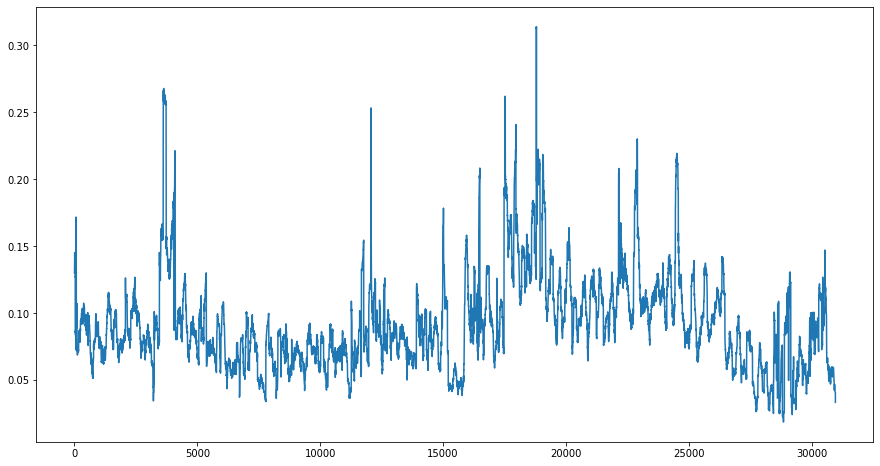

In [5]:
import matplotlib.pyplot  as plt
fig = plt.figure(figsize=(15,8))
plt.plot(y)

In [47]:
# from statsmodels.tsa.arima.model import ARIMA
# # 1. initialize the model
# arima = ARIMA(y, order=(1, 0,0))
# # 2. fit the models
# arima_fit = arima.fit()
# arima_fit.summary()

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA


end_train = int(.8*len(y))
y_train = y[:end_train]
X_train = X[:end_train]
y_test = y[(end_train+1):]
X_test = X[(end_train+1):]


for lag in range(30,100,2):

    new_y = pd.concat((
        y_train,
        y_train.shift(30).rename(columns={'realized_volatility':'lag_y'}),
        y_train.shift(2*lag).rename(columns={'realized_volatility':'lag_y_2'}),
        X_train['spread'].shift(lag),
        X_train['spread_sq'].shift(lag),
        X_train['BBAOFI'].shift(lag),        
        X_train['FDOFI'].shift(lag),            
            # X['First2OFI'].shift(lag), 
            # X['full_bid_depth'].shift(lag),
            # X['full_ask_depth'].shift(lag),
        ), axis=1).dropna()
    
    new_y_test = pd.concat((
        y_test,
        y_test.shift(30).rename(columns={'realized_volatility':'lag_y'}),
        y_test.shift(2*lag).rename(columns={'realized_volatility':'lag_y_2'}),
        X_test['spread'].shift(lag),
        X_test['spread_sq'].shift(lag),
        X_test['BBAOFI'].shift(lag),        
        X_test['FDOFI'].shift(lag),            
            # X['First2OFI'].shift(lag), 
            # X['full_bid_depth'].shift(lag),
            # X['full_ask_depth'].shift(lag),
        ), axis=1).dropna()

    y_=new_y['realized_volatility']
    X_=new_y.drop(columns='realized_volatility')
    
    y_t=new_y_test['realized_volatility']
    X_t=new_y_test.drop(columns='realized_volatility')
    
    
    reg = LinearRegression()
    reg.fit(X=X_, y=y_)
    print([lag, reg.score(X=X_, y=y_), reg.score(X=X_t, y=y_t)])





[30, 0.7488647460861029, 0.6197697699946645]
[32, 0.7493112873513609, 0.6198339671356154]
[34, 0.7501201776634722, 0.6199073826564474]
[36, 0.7509649220533777, 0.6199855042558547]
[38, 0.7511653210315776, 0.6203396576191988]
[40, 0.7511485932569485, 0.6209366057377643]
[42, 0.7512299072992377, 0.6211886678097931]
[44, 0.7513400827836902, 0.6210942233390264]
[46, 0.7514386195320248, 0.6211385602331437]
[48, 0.751650534884669, 0.6215217920363032]
[50, 0.7519340631218462, 0.6223883035516669]
[52, 0.7522061304848824, 0.6233531348972705]
[54, 0.7521272380947462, 0.6244093176993051]
[56, 0.7520443949692979, 0.6255379383225956]
[58, 0.751991434959733, 0.6268237383886467]
[60, 0.7520101534389709, 0.6278189384927377]
[62, 0.7521945073945364, 0.6290716078011714]
[64, 0.7525248408998285, 0.6301120237011969]
[66, 0.7529232955030467, 0.6310711438830571]
[68, 0.7532404580515312, 0.6319852457937608]
[70, 0.7536476854384258, 0.6326359583537475]
[72, 0.7540004648250351, 0.6328867863517327]
[74, 0.75422

In [49]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.linear_model import SGDClassifier

gboost = GradientBoostingRegressor(n_estimators=100)
ridge = Ridge()
svm = SVR(C=1, epsilon=0.05)
lr = LinearRegression()
lr_lr = lambda x: np.exp(LinearRegression())

adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=None))

# grid = {
#         'gradientboostingregressor__n_estimators': stats.randint(50,300),
#         'gradientboostingregressor__learning_rate':stats.uniform(0.05,0.3),
#         'gradientboostingregressor__loss': ['ls', 'lad', 'huber', 'quantile'],
        
#     }



reg = StackingRegressor(
    estimators=[
                ("gboost", gboost),
                ("adaboost", adaboost),
                # ("ridge", ridge), 
                ("svm_rbf", svm)
                ],    
    final_estimator=lr,
    cv=None,
    n_jobs=-1
)
reg.fit(X_, y_)
[reg.score(X_, y_), reg.score(X_t, y_t)]


[0.793340549705049, 0.5465240606966495]

In [ ]:
reg.score(X_t, y_t)

In [346]:
new_y = pd.concat((y,y.shift(lag)), axis=1).dropna()

new_y.columns=['vt','vt-1']
new_y

,vt,vt-1
30,0.127662,0.129871
31,0.085429,0.136426
32,0.085429,0.136368
33,0.085429,0.137430
34,0.086361,0.137775
...,...,...
30960,0.041152,0.046967
30961,0.041079,0.046911
30962,0.041076,0.046942
30963,0.040427,0.045818


In [352]:
import numpy as np
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, random_state=0).fit(new_y)
labels = gm.predict(new_y)
# labels=labels>0
print('0 :'+str(np.sum(labels==0)))
print('1 :'+str(np.sum(labels==1)))
print('2 :'+str(np.sum(labels==2)))
print('3 :'+str(np.sum(labels==3)))
print(len(y))



0 :17542
1 :2747
2 :10646
3 :0
30965


In [353]:
new_y2 = pd.concat((new_y,pd.DataFrame({'labels':labels})), axis=1).dropna()
# new_y2.columns=['vt','vt-1']
new_y2

,vt,vt-1,labels
30,0.127662,0.129871,2.0
31,0.085429,0.136426,1.0
32,0.085429,0.136368,1.0
33,0.085429,0.137430,1.0
34,0.086361,0.137775,1.0
...,...,...,...
30930,0.046967,0.053454,0.0
30931,0.046911,0.053450,0.0
30932,0.046942,0.052029,0.0
30933,0.045818,0.050192,0.0


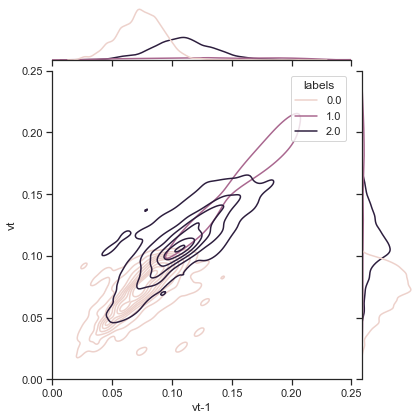

In [354]:
import seaborn as sns
sns.set_theme(style="ticks")



# Show the joint distribution using kernel density estimation
g = sns.jointplot(
    data=new_y2,
    x="vt-1", y="vt", hue='labels',
    ylim=[0,.25],
    xlim=[0,.25],
    kind="kde",
)

/Users/fipm/.pyenv/versions/3.8.12/envs/thalassa/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/fipm/.pyenv/versions/3.8.12/envs/thalassa/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<AxesSubplot:title={'center':'Probability of being in a low-variance regime'}>

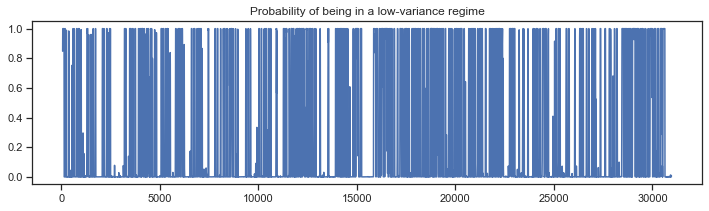

In [322]:
import statsmodels.api as sm
lag=30
new_y = pd.concat((
    y,
    y.shift(lag).rename(columns={'realized_volatility':'lag_y'}),
    y.shift(2*lag).rename(columns={'realized_volatility':'lag_y'}),
    X['spread'].shift(lag),
    # # X['full_bid_depth'].shift(lag),
    # # X['full_ask_depth'].shift(lag),
    X['BBAOFI'].shift(lag),
    # # X['First2OFI'].shift(lag), 
    X['FDOFI'].shift(lag),            
    ), axis=1).dropna()

y_=new_y['realized_volatility']
X_=new_y.drop(columns='realized_volatility')


mod_hamilton = sm.tsa.MarkovRegression(
    y_, k_regimes=2, 
    exog=X_,
    switching_variance=True
)
res_hamilton = mod_hamilton.fit()
res_hamilton.summary()
res_hamilton.smoothed_marginal_probabilities[0].plot(
    title="Probability of being in a low-variance regime", figsize=(12, 3)
)

In [325]:
np.sum(res_hamilton.smoothed_marginal_probabilities[0]>.75)

8318